In [2]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"
from matplotlib.patches import Circle, Ellipse
from scipy.stats import multivariate_normal
import numpy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
#from tabulate import tabulate  # Install using `pip install tabulate` if not available


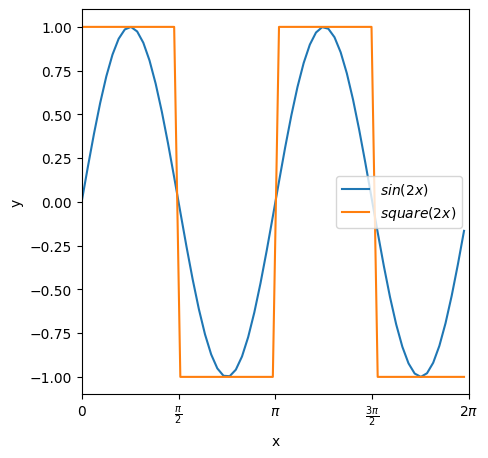

In [3]:
def functions(x, noise_variance=None):
    y_sin = np.sin(2*x)
    y_square = np.sign(y_sin)
    y_square[y_square==0] = 1
    if noise_variance is not None:
        std = np.sqrt(noise_variance)
        y_sin += np.random.normal(scale=std, size=y_sin.shape)
        y_square += np.random.normal(scale=std, size=y_square.shape)
    return y_sin, y_square

x = np.arange(0, 2*np.pi, 0.1)[:,np.newaxis]
x_test = np.arange(0.05, 2*np.pi, 0.1)[:,np.newaxis]
y_sin, y_square = functions(x, noise_variance=None)
y_sin_test, y_square_test = functions(x_test, noise_variance=None)

# Plot functions
plt.figure(figsize=(5,5))
plt.plot(x, y_sin, label="$sin(2x)$")
plt.plot(x, y_square, label="$square(2x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend()



In [4]:
DEFAULT_NODES = 10
DEFAULT_NODE_POS = 'equal'
DEFAULT_NODE_STD = 1
DEFAULT_CL_SYMMETRICAL = False
DEFAULT_CL_RANDOM_START = True
DEFAULT_CL_LEARNING_RATE = 0.2
DEFAULT_CL_EPOCHS = 100
DEFAULT_CL_BIAS = False
DEFAULT_CL_BIAS_WEIGHT = 0.01
DEFAULT_CL_VERBOSE = False
DEFAULT_LEARNING_RATE_DELTA = 0.1
DEFAULT_EPOCHS_DELTA = 100
DEFAULT_SHUFFLE_DELTA = False
DEFAULT_POSTPROCESSING = None
DEFAULT_TRAINING = 'least_squares'
DEFAULT_RUNS = 10

class GaussianRBFNetwork:

    def __init__(self,
                 data,
                 nodes=DEFAULT_NODES,
                 node_pos=DEFAULT_NODE_POS,
                 node_std=DEFAULT_NODE_STD,
                 cl_symmetrical=DEFAULT_CL_SYMMETRICAL,
                 cl_random_start=DEFAULT_CL_RANDOM_START,
                 cl_learning_rate=DEFAULT_CL_LEARNING_RATE,
                 cl_epochs=DEFAULT_CL_EPOCHS,
                 cl_bias=DEFAULT_CL_BIAS,
                 cl_bias_weight=DEFAULT_CL_BIAS_WEIGHT,
                 cl_verbose=DEFAULT_CL_VERBOSE,
                 postprocessing=DEFAULT_POSTPROCESSING
                ):

        self.data = data
        self.nodes = nodes
        self.node_pos = node_pos
        self.postprocessing = postprocessing
        
        # Define initial node position by competitive learning
        if self.node_pos=='cl':
            self.init_kernels_cl(std=node_std,
                                 random_start=cl_random_start,
                                 learning_rate=cl_learning_rate,
                                 epochs=cl_epochs,
                                 bias=cl_bias,
                                 bias_weight=cl_bias_weight,
                                 verbose=cl_verbose)
        
        # Define initial node position randomly
        elif self.node_pos=='random':
            self.mu = np.array([self.data[np.random.randint(self.data.shape[0]),:] \
                                for _ in range(self.nodes)])
            self.cov = np.full(self.nodes, node_std**2)
        
        # Define initial node position equally
        elif self.node_pos=='equal':
            low, high = self.data[0], self.data[-1]
            self.mu = np.linspace(low, high, self.nodes)
            self.cov = np.full(self.nodes, node_std**2)
        
        # Define initial node position manually
        elif self.node_pos=='manual':
            pass
        
        # Initialize the weights that connect to the output layer
        self.weights = np.random.randn(self.nodes, 1)
        
    def init_kernels_cl(self,
                        std=DEFAULT_NODE_STD,
                        random_start=DEFAULT_CL_RANDOM_START,
                        learning_rate=DEFAULT_CL_LEARNING_RATE,
                        epochs=DEFAULT_CL_EPOCHS,
                        bias=DEFAULT_CL_BIAS,
                        bias_weight=DEFAULT_CL_BIAS_WEIGHT,
                        verbose=DEFAULT_CL_VERBOSE):
        
        # Define the units centers and covariances (if required)
        if random_start:
            self.mu = np.array([self.data[np.random.randint(self.data.shape[0]),:] \
                                for _ in range(self.nodes)])
            self.cov = np.full(self.nodes, std**2)        
        
        # Intialize the matrix for counting the winners
        winnings = np.zeros((self.mu.shape[0],1), dtype=int)
        
        # Define the bias matrix for penalizing winners (if required)
        if bias:
            biases = np.full((self.mu.shape[0],1), 1/self.nodes)
        
        # Iterate the epochs of competitive learning process
        samples_ = self.data.copy()
        for i in range(epochs):
            
            # Shufflle and iterate the samples
            np.random.shuffle(samples_)
            for sample in samples_:
                
                # Compute the error of the sample to each unit
                err = sample-self.mu
                
                # Compute the distances from the sample to each unit
                d = np.sum(err*err, axis=1).reshape(self.nodes, 1)
                
                # Penalize the winners
                if bias:
                    d -= bias_weight*biases
                
                # Find the winners (closest unit to the sample)
                i = np.argmin(d)
                self.mu[i,:] += learning_rate*err[i,:]
                winnings[i] += 1
                
                # Update the bias for penalizing winners
                if bias:
                    biases = 1/self.nodes-winnings/(i+1)

        if verbose:
            print("CL summary:")
            print("  - Weights and Winning Times are:")
            for pos, wins in zip(self.mu, winnings):
                print(" x: ", pos, " -> ", wins[0])

    def least_squares_fit(self, inputs, outputs):
        phi = np.array([[multivariate_normal.pdf(x, mean=self.mu[i], cov=self.cov[i]) \
                         for i in range(self.nodes)] for x in inputs])
        self.weights, _, _, _ = la.lstsq(phi, np.ravel(outputs), rcond=None)
        self.weights = self.weights[:,np.newaxis]

    def delta_rule_train(self,
                         inputs,
                         outputs,
                         learning_rate=DEFAULT_LEARNING_RATE_DELTA,
                         epochs=DEFAULT_EPOCHS_DELTA,
                         shuffle=DEFAULT_SHUFFLE_DELTA,
                         improve=False):
        if not improve:
            self.weights = np.random.randn(self.nodes, 1)
        for _ in range(epochs):
            if shuffle:
                np.random.shuffle(inputs)
            for sample, expected in zip(inputs, outputs):
                phi = np.array([multivariate_normal.pdf(sample, mean=self.mu[i], cov=self.cov[i]) \
                                for i in range(self.nodes)])[:,np.newaxis]
                err = expected-phi.T@self.weights
                self.weights += learning_rate*err*phi

    def predict(self, inputs):
        # Predict the inputs
        pred = np.array([[multivariate_normal.pdf(x, mean=self.mu[i], cov=self.cov[i]) \
                          for i in range(self.nodes)] for x in inputs]) @ self.weights
        
        # Postpreporcess the inputs (if required)
        if self.postprocessing is not None:
            pred = self.postprocessing(pred)
        
        return pred

In [5]:
def profile_nodes_sigma(x, x_test,
                        y, y_test,
                        nodes_profile,
                        nodes_preview,
                        kwargs_network={},
                        kwargs_training={}
                       ):

    if 'training' in kwargs_training:
        training = kwargs_training['training']
        kwargs_training.pop('training')
    else:
        training = DEFAULT_TRAINING
    
    if 'node_std' in kwargs_network:
        node_std = kwargs_network['node_std']
        kwargs_network.pop('node_std')
    else:
        node_std = DEFAULT_NODE_STD

    def fit_model(nodes, sigma=DEFAULT_NODE_STD):
        model = GaussianRBFNetwork(data=x, nodes=nodes, node_std=sigma, **kwargs_network)
        if training == 'least_squares':
            model.least_squares_fit(x, y)
        elif training == 'delta_rule':
            model.delta_rule_train(x, y, **kwargs_training)
        return model
    
    # Preview
    fig = plt.figure(figsize=(15, 7.5))
    fig.add_subplot(221)
    plt.plot(x_test, y_test, label="Ground Truth")
    models_preview = {}  # Store models for later prediction
    for ns in nodes_preview:
        model = fit_model(ns)
        models_preview[ns] = model
        predictions_test = model.predict(x_test)
        plt.plot(x_test, predictions_test, label=str(ns) + " units")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    
    # Profiling
    fig.add_subplot(222)
    sigma_residuals = []  # Store (sigma, residuals) pairs
    for sigma in [node_std] if isinstance(node_std, (float, int)) else node_std:
        residuals = []
        for ns in nodes_profile:
            model = fit_model(ns, sigma)
            predictions_test = model.predict(x_test)
            residuals.append(np.mean(np.abs(predictions_test - y_test.reshape(-1, 1))))
        sigma_residuals.append((sigma, residuals))
        plt.plot(nodes_profile, residuals, linestyle='--', marker='o', label="sigma=" + str(sigma))
    plt.legend()
    plt.xlabel("Number of Units")
    plt.ylabel("Residual Error")
    for residual_threshold in [0.1, 0.01, 0.001]:
        plt.axhline(residual_threshold, color='r', linestyle='--')

    # Define ranges for outputs (edit these as needed)
    nodes_residual_print = range(2, 11, 2)  # Residual nodes: 2,4,6,8,10
    x_values_to_print = np.arange(1, 11)     # X-values: 1-10 (inclusive)

    # Print residual errors
    print("\nResidual Errors:")
    for sigma, residuals in sigma_residuals:
        print(f"\nSigma = {sigma}:")
        print("Nodes\tResidual Error")
        for ns in nodes_residual_print:
            if ns in nodes_profile:
                idx = nodes_profile.index(ns)
                print(f"{ns}\t{residuals[idx]:.4f}")
            else:
                print(f"{ns} not in nodes_profile")

    # Print predictions for previewed models
    print("\nPredictions for Selected X-Values:")
    header = "X\t" + "\t".join([f"{ns} units" for ns in nodes_preview])
    print(header)
    for x in x_values_to_print:
        row = [f"{x}"]
        for ns in nodes_preview:
            model = models_preview[ns]
            y_pred = model.predict(np.array([[x]]))[0][0]  # Predict single value
            row.append(f"{y_pred:.4f}")
        print("\t".join(row))



Residual Errors:

Sigma = 1:
Nodes	Residual Error
2	0.5054
4	0.3811
6	0.0715
8	0.0105
10	0.0015

Predictions for Selected X-Values:
X	2 units	4 units	6 units	8 units	10 units	20 units
1	0.4136	0.2563	0.8753	0.9217	0.9100	0.9093
2	0.0922	-0.5314	-0.7373	-0.7677	-0.7552	-0.7568
3	0.0033	-0.0742	-0.2943	-0.2762	-0.2797	-0.2794
4	-0.0630	0.5622	1.0056	0.9963	0.9872	0.9894
5	-0.3462	-0.0381	-0.5639	-0.5608	-0.5436	-0.5440
6	-0.6972	-1.0125	-0.5864	-0.5284	-0.5336	-0.5366
7	-0.5165	-0.8395	0.0794	0.6856	0.9493	1.0096
8	-0.1408	-0.2319	0.0722	0.3510	0.5332	0.2211
9	-0.0141	-0.0233	0.0088	0.0427	0.0700	-0.1725
10	-0.0005	-0.0009	0.0003	0.0017	0.0029	-0.0265


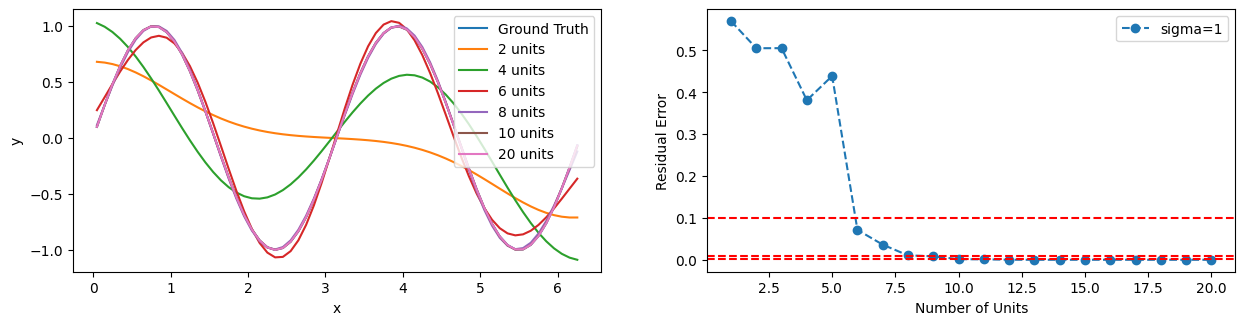

In [6]:
# Example usage
profile_nodes_sigma(x, x_test, y_sin, y_sin_test, 
                    nodes_profile=range(1, 21), 
                    nodes_preview=[2, 4, 6, 8, 10, 20])


Residual Errors:

Sigma = 1:
Nodes	Residual Error
2	0.6752
4	0.5051
6	0.2908
8	0.2912
10	0.2644

Predictions for Selected X-Values:
X	5 units	10 units	15 units	30 units
1	0.4059	1.1103	1.2452	0.9970
2	-0.5497	-1.0596	-1.0554	-1.1903
3	-0.1891	-0.3380	-0.5579	-0.6591
4	0.5925	1.3237	1.0180	0.8289
5	0.0866	-0.6984	-0.8727	-1.0704
6	-1.5322	-0.9513	-1.2358	-0.9585
7	-1.4131	-1.8830	52.7454	161.3445
8	-0.4013	-1.1552	116.6479	-2837.5692
9	-0.0406	-0.1686	33.3136	-6695.4397
10	-0.0015	-0.0074	2.2334	-1629.9438


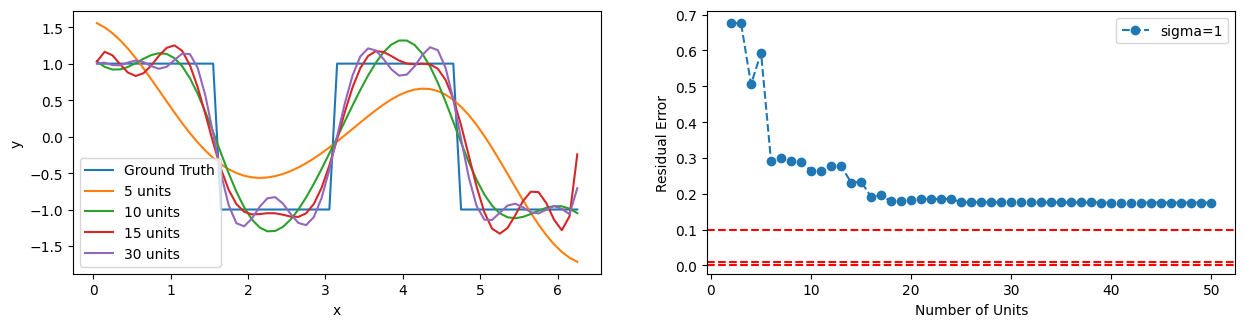

In [7]:
profile_nodes_sigma(x, x_test, y_square, y_square_test, nodes_profile=range(2, 51), 
                    nodes_preview=[5,10,15,30])


Residual Errors:

Sigma = 1:
Nodes	Residual Error
2	0.9841
4	0.1905
6	0.0000
8	0.0317
10	0.0317

Predictions for Selected X-Values:
X	4 units	5 units	6 units
1	1.0000	1.0000	1.0000
2	-1.0000	-1.0000	-1.0000
3	-1.0000	-1.0000	-1.0000
4	1.0000	1.0000	1.0000
5	-1.0000	1.0000	-1.0000
6	-1.0000	-1.0000	-1.0000
7	-1.0000	-1.0000	-1.0000
8	-1.0000	-1.0000	-1.0000
9	-1.0000	-1.0000	-1.0000
10	-1.0000	-1.0000	-1.0000


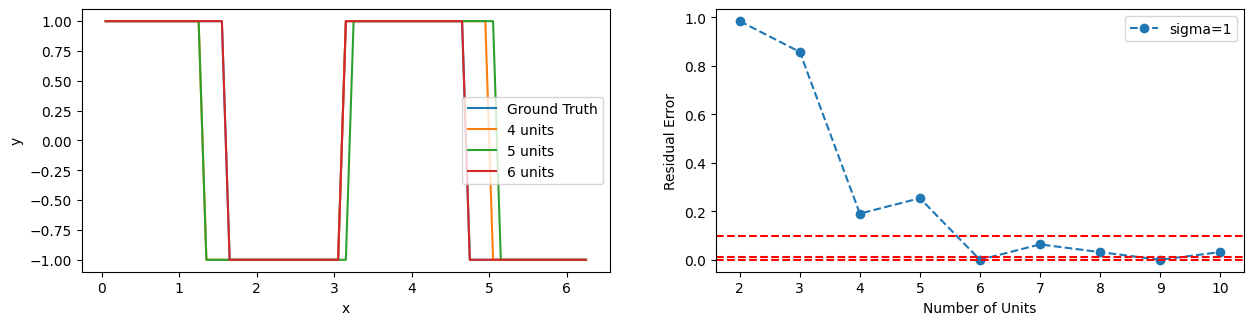

In [8]:
profile_nodes_sigma(x, x_test, y_square, y_square_test, nodes_profile=range(2, 11), nodes_preview=[4,5,6],
                    kwargs_network={'postprocessing': lambda prediction: np.sign(prediction)})

# 3.2 Regression noise

In [ ]:
#### 3.2.1. Compare the exect of the number of RBF units and their width for 


Residual Errors:

Sigma = 0.1:
Nodes	Residual Error
2	0.6299
4	0.5547
6	0.5111
8	0.4563
10	0.4092

Sigma = 1.0:
Nodes	Residual Error
2	0.5054
4	0.3811
6	0.0715
8	0.0105
10	0.0015

Sigma = 10.0:
Nodes	Residual Error
2	0.5614
4	0.5318
6	0.1872
8	0.1879
10	0.1880

Sigma = 100.0:
Nodes	Residual Error
2	0.5600
4	0.5347
6	0.5347
8	0.5347
10	0.5347

Predictions for Selected X-Values:
X	5 units	10 units	30 units
1	0.2681	0.9100	0.9093
2	-0.3409	-0.7552	-0.7568
3	-0.1320	-0.2797	-0.2794
4	0.3903	0.9872	0.9894
5	0.0462	-0.5436	-0.5440
6	-1.0688	-0.5336	-0.5366
7	-0.9821	0.9493	0.9965
8	-0.2787	0.5332	-0.0264
9	-0.0282	0.0700	-0.4635
10	-0.0010	0.0029	-0.0814


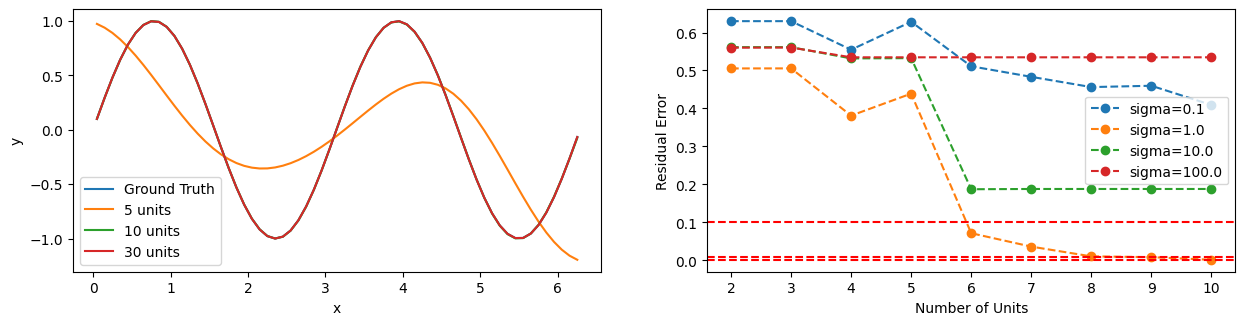

In [9]:
profile_nodes_sigma(x, x_test, y_sin, y_sin_test, nodes_profile=range(2, 11), nodes_preview=[5,10,30],
                    kwargs_network={'node_std': np.logspace(-1, 2, 4)}, 
                    kwargs_training={'training': 'least_squares'})


Residual Errors:

Sigma = 0.1:
Nodes	Residual Error
2	0.6330
4	0.5584
6	0.5220
8	0.4717
10	0.4277

Sigma = 1.0:
Nodes	Residual Error
2	0.5052
4	0.3807
6	0.2640
8	0.2204
10	0.2475

Sigma = 10.0:
Nodes	Residual Error
2	0.6339
4	0.6321
6	0.6349
8	0.6333
10	0.6316

Sigma = 100.0:
Nodes	Residual Error
2	0.6350
4	0.6350
6	0.6350
8	0.6349
10	0.6353

Predictions for Selected X-Values:
X	5 units	10 units	30 units
1	0.2385	0.6020	0.7358
2	-0.3755	-0.6477	-0.7246
3	-0.0703	-0.1762	-0.2143
4	0.3771	0.7539	0.8900
5	-0.0026	-0.3048	-0.4723
6	-1.0014	-0.8093	-0.6364
7	-0.9006	-0.3129	0.0294
8	-0.2546	-0.0412	0.0674
9	-0.0257	-0.0020	0.0087
10	-0.0010	-0.0000	0.0003


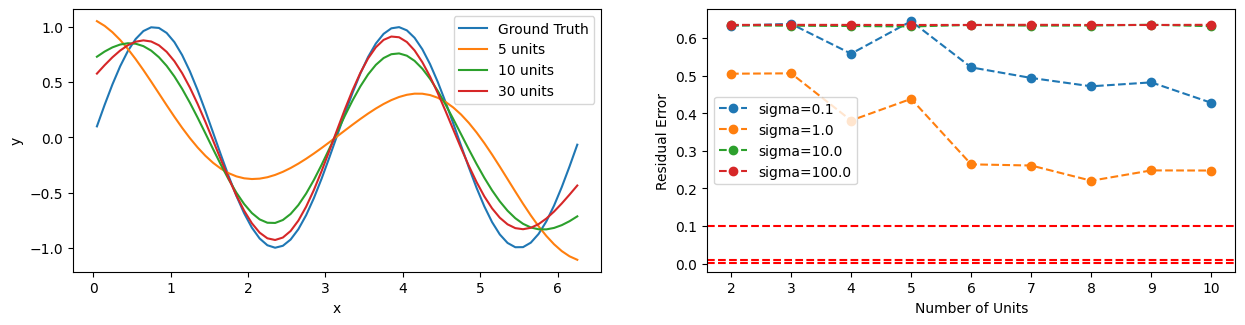

In [10]:
profile_nodes_sigma(x, x_test, y_sin, y_sin_test, nodes_profile=range(2, 11), nodes_preview=[5,10,30],
                    kwargs_network={'node_std': np.logspace(-1, 2, 4)},
                    kwargs_training={'training': 'delta_rule'})

#### 3.2.2. What can you say about the rate of convergence and its dependence on the learning rate, eta, for the two learning schemes?

In [11]:

def profile_convergence(x, x_test, y, y_test, kwargs_network={}, kwargs_training={}, runs=DEFAULT_RUNS):
    if 'training' in kwargs_training:
        training = kwargs_training['training']
        kwargs_training.pop('training')
    else:
        training = DEFAULT_TRAINING
    
    if 'node_std' in kwargs_network:
        node_std = kwargs_network['node_std']
        kwargs_network.pop('node_std')
    else:
        node_std = DEFAULT_NODE_STD
        
    if 'learning_rate' in kwargs_training:
        learning_rate = kwargs_training['learning_rate']
        kwargs_training.pop('learning_rate')
    else:
        learning_rate = DEFAULT_LEARNING_RATE_DELTA
    
    if 'epochs' in kwargs_training:
        epochs = kwargs_training['epochs']
        kwargs_training.pop('epochs')
    else:
        epochs = DEFAULT_EPOCHS_DELTA

    # Define auxiliary function for computing the MAE by epochs given a learning rate
    def learning_curve(learning_rate):
        residuals = []
        for epoch in range(epochs):
            model.delta_rule_train(x, y, learning_rate=learning_rate, epochs=1, improve=True, **kwargs_training)
            predictions_test = model.predict(x_test)
            residual_error = np.mean(np.abs(predictions_test - y_test.reshape(y_test.shape[0], 1)))
            residuals.append(residual_error)
            
            # Print residual error every 20 epochs
            if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch + 1}, eta={learning_rate}, Residual Error: {residual_error:.6f}")
        
        return residuals

    # Create figure with better aesthetics
    plt.figure(figsize=(10, 6))
    plt.style.use('ggplot')  # Set a more modern style
    
    cmap = plt.get_cmap('viridis')  # Change colormap for better differentiation
    
    for i, lr in enumerate(learning_rate):
        if kwargs_network.get('node_pos') == 'random':
            for r in range(runs):
                # Initialize model
                model = GaussianRBFNetwork(data=x, **kwargs_network)
                plt.plot(range(1, epochs + 1), learning_curve(lr), color=cmap(i / len(learning_rate)), alpha=0.5, 
                         linewidth=2, linestyle='-', marker='o', markersize=4, label=f"eta={lr}")
        else:
            # Initialize model
            model = GaussianRBFNetwork(data=x, **kwargs_network)    
            plt.plot(range(1, epochs + 1), learning_curve(lr), color=cmap(i / len(learning_rate)), linewidth=3, 
                     linestyle='-', marker='s', markersize=4, label=f"eta={lr}")

    # Add threshold lines with better formatting
    for residual_threshold in [0.1, 0.01, 0.001]:
        plt.axhline(residual_threshold, color='red', linestyle='--', linewidth=2, alpha=0.8, 
                    label=f"Threshold: {residual_threshold}")

    # Set labels and legend with larger fonts
    plt.xlabel("Epochs", fontsize=14, fontweight='bold')
    plt.ylabel("Residual Error", fontsize=14, fontweight='bold')
    plt.title("Convergence Profile", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, loc="upper right", frameon=True)

    # Customize grid for better readability
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Show plot
    plt.show()


Epoch 20, eta=0.01, Residual Error: 0.567175
Epoch 40, eta=0.01, Residual Error: 0.487536
Epoch 60, eta=0.01, Residual Error: 0.436768
Epoch 80, eta=0.01, Residual Error: 0.400835
Epoch 100, eta=0.01, Residual Error: 0.376484
Epoch 20, eta=0.1, Residual Error: 0.339574
Epoch 40, eta=0.1, Residual Error: 0.301105
Epoch 60, eta=0.1, Residual Error: 0.272737
Epoch 80, eta=0.1, Residual Error: 0.247794
Epoch 100, eta=0.1, Residual Error: 0.225122
Epoch 20, eta=1.0, Residual Error: 0.261842
Epoch 40, eta=1.0, Residual Error: 0.141429
Epoch 60, eta=1.0, Residual Error: 0.079081
Epoch 80, eta=1.0, Residual Error: 0.056332
Epoch 100, eta=1.0, Residual Error: 0.055072


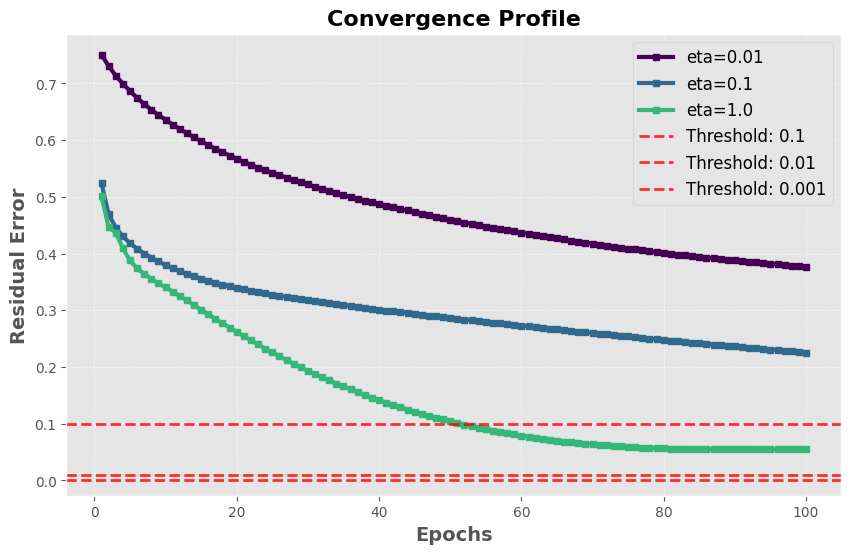

In [12]:
profile_convergence(x, x_test, y_sin, y_sin_test,
                    kwargs_training={'learning_rate': np.logspace(-2, 0, 3)})

#### 3.2.3. What are the main effets of changing the width of RBFs? 

In [13]:

def profile_rbf_widths(x, x_test, y, y_test, kwargs_network={}, kwargs_training={}):
    plt.figure(figsize=(10, 6))  # Adjust figure size
    plt.style.use('ggplot')  # Apply modern style
    
    # Plot ground truth
    plt.plot(x_test, y_test, label="Ground Truth", color="black", linewidth=3, linestyle='dashed')

    # Extract parameters
    training = kwargs_training.pop('training', DEFAULT_TRAINING)
    node_std = kwargs_network.pop('node_std', DEFAULT_NODE_STD)
    
    # Define color map for different sigma values
    cmap = plt.get_cmap('viridis')
    sigma_list = [node_std] if isinstance(node_std, (float, int)) else node_std

    # Iterate over different sigma values
    for i, sigma in enumerate(sigma_list):
        model = GaussianRBFNetwork(data=x, node_std=sigma, **kwargs_network)

        # Choose training method
        if training == 'least_squares':
            model.least_squares_fit(x, y)
        elif training == 'delta_rule':
            model.delta_rule_train(x, y, **kwargs_training)

        # Predict values
        predictions_test = model.predict(x_test)

        # Print x and corresponding y values
        print(f"\nSigma = {sigma}:")
        for x_val, y_true, y_pred in zip(x_test, y_test, predictions_test):
            # Ensure single-value formatting
            y_pred_value = y_pred.item() if isinstance(y_pred, np.ndarray) and y_pred.size == 1 else float(y_pred)
            print(f"x: {float(x_val):.4f}, y_true: {float(y_true):.4f}, y_pred: {y_pred_value:.4f}")

        # Plot predictions
        plt.plot(x_test, predictions_test, label=f"Sigma = {sigma}", 
                 color=cmap(i / len(sigma_list)), linewidth=2.5, linestyle='-')

    # Improve labels and grid
    plt.xlabel("x", fontsize=14, fontweight='bold')
    plt.ylabel("y", fontsize=14, fontweight='bold')
    plt.title("RBF Widths and Predictions", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, loc="upper right", frameon=True)

    # Customize grid for better readability
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    # Show plot
    plt.show()



Sigma = 0.1:
x: 0.0500, y_true: 0.0998, y_pred: 0.1144
x: 0.1500, y_true: 0.2955, y_pred: 0.0421
x: 0.2500, y_true: 0.4794, y_pred: 0.0058
x: 0.3500, y_true: 0.6442, y_pred: 0.0046
x: 0.4500, y_true: 0.7833, y_pred: 0.0784
x: 0.5500, y_true: 0.8912, y_pred: 0.5185
x: 0.6500, y_true: 0.9636, y_pred: 1.2613
x: 0.7500, y_true: 0.9975, y_pred: 1.1286
x: 0.8500, y_true: 0.9917, y_pred: 0.3715
x: 0.9500, y_true: 0.9463, y_pred: 0.0451
x: 1.0500, y_true: 0.8632, y_pred: 0.0044
x: 1.1500, y_true: 0.7457, y_pred: 0.0390
x: 1.2500, y_true: 0.5985, y_pred: 0.2307
x: 1.3500, y_true: 0.4274, y_pred: 0.5022
x: 1.4500, y_true: 0.2392, y_pred: 0.4021
x: 1.5500, y_true: 0.0416, y_pred: 0.1184
x: 1.6500, y_true: -0.1577, y_pred: 0.0126
x: 1.7500, y_true: -0.3508, y_pred: -0.0072
x: 1.8500, y_true: -0.5298, y_pred: -0.1110
x: 1.9500, y_true: -0.6878, y_pred: -0.5875
x: 2.0500, y_true: -0.8183, y_pred: -1.1443
x: 2.1500, y_true: -0.9162, y_pred: -0.8199
x: 2.2500, y_true: -0.9775, y_pred: -0.2161
x: 2.35

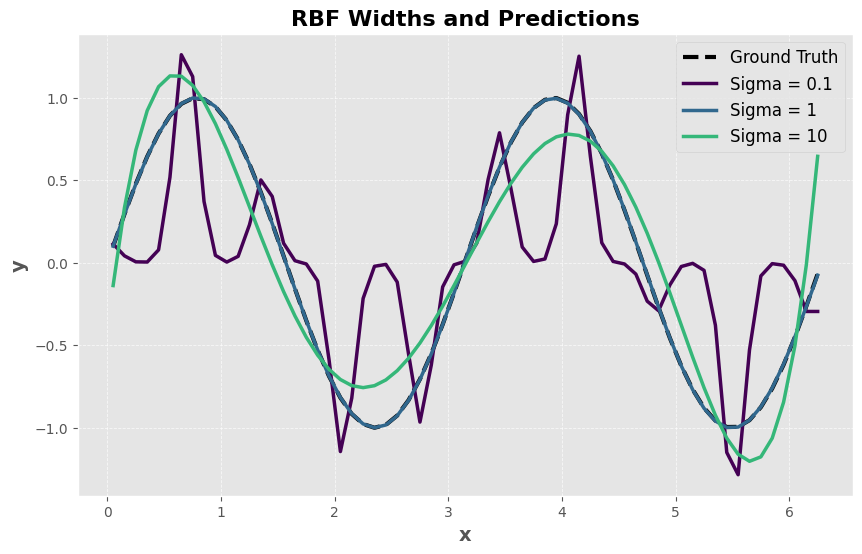

In [14]:
profile_rbf_widths(x, x_test, y_sin, y_sin_test, kwargs_network={'node_std': [0.1,1,10]})

#### 3.2.4. How important is the positioning of the RBF nodes in the input space? What strategy did you choose? Is it better than random positioning of the RBF nodes?

Epoch 20, eta=0.0001, Residual Error: 0.787426
Epoch 40, eta=0.0001, Residual Error: 0.785664
Epoch 60, eta=0.0001, Residual Error: 0.783918
Epoch 80, eta=0.0001, Residual Error: 0.782187
Epoch 100, eta=0.0001, Residual Error: 0.780472
Epoch 20, eta=0.0001, Residual Error: 0.838304
Epoch 40, eta=0.0001, Residual Error: 0.826933
Epoch 60, eta=0.0001, Residual Error: 0.815829
Epoch 80, eta=0.0001, Residual Error: 0.804986
Epoch 100, eta=0.0001, Residual Error: 0.794395
Epoch 20, eta=0.0001, Residual Error: 0.541217
Epoch 40, eta=0.0001, Residual Error: 0.538446
Epoch 60, eta=0.0001, Residual Error: 0.535717
Epoch 80, eta=0.0001, Residual Error: 0.533031
Epoch 100, eta=0.0001, Residual Error: 0.530385
Epoch 20, eta=0.001, Residual Error: 0.794373
Epoch 40, eta=0.001, Residual Error: 0.655231
Epoch 60, eta=0.001, Residual Error: 0.605071
Epoch 80, eta=0.001, Residual Error: 0.583486
Epoch 100, eta=0.001, Residual Error: 0.572791
Epoch 20, eta=0.001, Residual Error: 0.589889
Epoch 40, eta=0

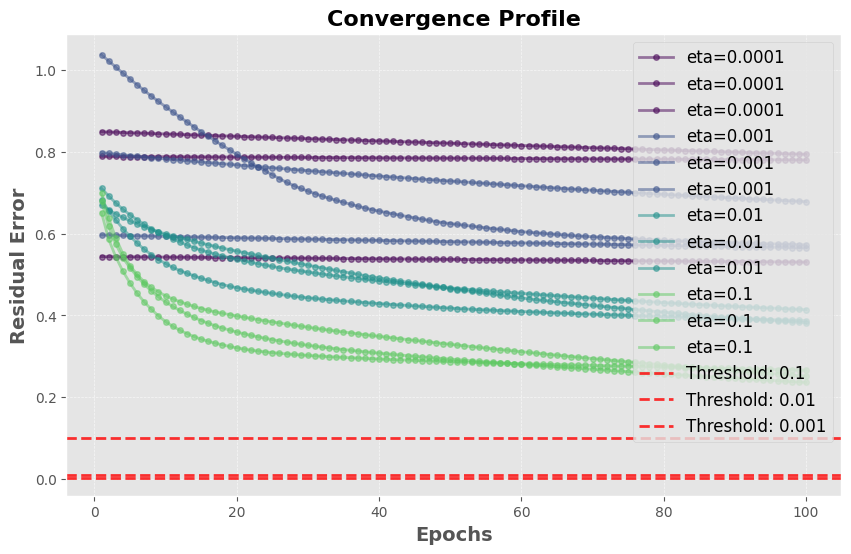

In [15]:
profile_convergence(x, x_test, y_sin, y_sin_test, kwargs_network={'node_pos': 'random'},
                    kwargs_training={'learning_rate': np.logspace(-4, -1, 4)}, runs=3)

#### 3.2.5. Also, for the same network models estimate their test performance on the original clean data used in section 3.1 (a corresponding test subset but without noise) and compare your findings.

In [16]:
y_noisy_sin, y_noisy_square = functions(x, noise_variance=0.1)
y_test_noisy_sin, y_test_noisy_square = functions(x_test, noise_variance=0.1)


def profile_clean_performance(x, y_noisy, x_test, y_test, nodes_preview, kwargs_network={}, 
                              kwargs_training={}):    

    def fit_model(nodes, sigma=DEFAULT_NODE_STD):
        model = GaussianRBFNetwork(data=x, nodes=nodes, node_std=sigma, **kwargs_network)
        if training == 'least_squares':
            model.least_squares_fit(x, y_noisy)
        elif training == 'delta_rule':
            model.delta_rule_train(x, y_noisy, **kwargs_training)
        
        return model
    
    # Set figure aesthetics
    plt.figure(figsize=(15, 7))
    plt.style.use('ggplot')  # Modern style
    cmap = plt.get_cmap('viridis')  # Improved color scheme

    # Preview Least Squares
    training = 'least_squares'
    plt.subplot(1, 2, 1)
    plt.plot(x_test, y_test, label="Ground Truth", color="black", linewidth=3, linestyle='dashed')

    for i, ns in enumerate(nodes_preview):
        model = fit_model(ns)
        predictions_test_clean = model.predict(x_test)

        # Print values for Least Squares
        print(f"\nLeast Squares - {ns} nodes:")
        for x_val, y_true, y_pred in zip(x_test, y_test, predictions_test_clean):
            y_pred_value = y_pred.item() if isinstance(y_pred, np.ndarray) and y_pred.size == 1 else float(y_pred)
            print(f"x: {float(x_val):.4f}, y_true: {float(y_true):.4f}, y_pred: {y_pred_value:.4f}")

        plt.plot(x_test, predictions_test_clean, label=f"{ns} units", 
                 color=cmap(i / len(nodes_preview)), linewidth=2.5, linestyle='-')

    plt.xlabel("x", fontsize=14, fontweight='bold')
    plt.ylabel("y", fontsize=14, fontweight='bold')
    plt.title("Least Squares trained on noisy", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, loc="upper right", frameon=True)
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    # Preview Delta Rule
    training = 'delta_rule'
    plt.subplot(1, 2, 2)
    plt.plot(x_test, y_test, label="Ground Truth", color="black", linewidth=3, linestyle='dashed')

    for i, ns in enumerate(nodes_preview):
        model = fit_model(ns)
        predictions_test_clean = model.predict(x_test)

        # Print values for Delta Rule
        print(f"\nDelta Rule - {ns} nodes:")
        for x_val, y_true, y_pred in zip(x_test, y_test, predictions_test_clean):
            y_pred_value = y_pred.item() if isinstance(y_pred, np.ndarray) and y_pred.size == 1 else float(y_pred)
            print(f"x: {float(x_val):.4f}, y_true: {float(y_true):.4f}, y_pred: {y_pred_value:.4f}")

        plt.plot(x_test, predictions_test_clean, label=f"{ns} units", 
                 color=cmap(i / len(nodes_preview)), linewidth=2.5, linestyle='-')

    plt.xlabel("x", fontsize=14, fontweight='bold')
    plt.ylabel("y", fontsize=14, fontweight='bold')
    plt.title("Delta Rule trained on noisy", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, loc="upper right", frameon=True)
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    # Show plot
    plt.tight_layout()  # Adjust layout to fit both subplots nicely
    plt.show()



Least Squares - 5 nodes:
x: 0.0500, y_true: 0.0998, y_pred: 0.8313
x: 0.1500, y_true: 0.2955, y_pred: 0.8125
x: 0.2500, y_true: 0.4794, y_pred: 0.7841
x: 0.3500, y_true: 0.6442, y_pred: 0.7466
x: 0.4500, y_true: 0.7833, y_pred: 0.7009
x: 0.5500, y_true: 0.8912, y_pred: 0.6478
x: 0.6500, y_true: 0.9636, y_pred: 0.5886
x: 0.7500, y_true: 0.9975, y_pred: 0.5245
x: 0.8500, y_true: 0.9917, y_pred: 0.4568
x: 0.9500, y_true: 0.9463, y_pred: 0.3868
x: 1.0500, y_true: 0.8632, y_pred: 0.3160
x: 1.1500, y_true: 0.7457, y_pred: 0.2453
x: 1.2500, y_true: 0.5985, y_pred: 0.1761
x: 1.3500, y_true: 0.4274, y_pred: 0.1091
x: 1.4500, y_true: 0.2392, y_pred: 0.0454
x: 1.5500, y_true: 0.0416, y_pred: -0.0145
x: 1.6500, y_true: -0.1577, y_pred: -0.0698
x: 1.7500, y_true: -0.3508, y_pred: -0.1202
x: 1.8500, y_true: -0.5298, y_pred: -0.1653
x: 1.9500, y_true: -0.6878, y_pred: -0.2046
x: 2.0500, y_true: -0.8183, y_pred: -0.2379
x: 2.1500, y_true: -0.9162, y_pred: -0.2648
x: 2.2500, y_true: -0.9775, y_pred: -

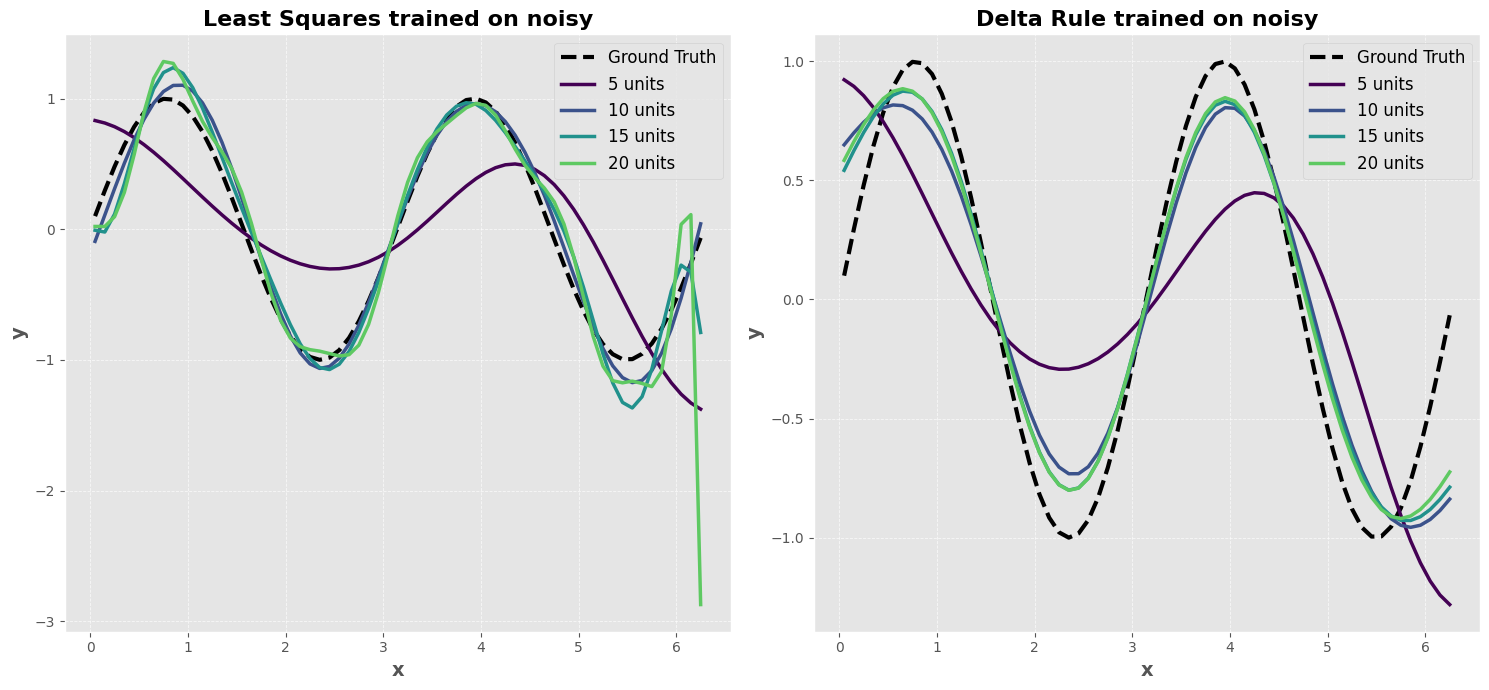

In [17]:
profile_clean_performance(x, y_noisy_sin, x_test, y_sin_test, nodes_preview=[5,10,15,20],
                          kwargs_network={}, kwargs_training={})


Least Squares - 5 nodes:
x: 0.0500, y_true: 1.0000, y_pred: 1.4384
x: 0.1500, y_true: 1.0000, y_pred: 1.3810
x: 0.2500, y_true: 1.0000, y_pred: 1.3042
x: 0.3500, y_true: 1.0000, y_pred: 1.2095
x: 0.4500, y_true: 1.0000, y_pred: 1.0989
x: 0.5500, y_true: 1.0000, y_pred: 0.9750
x: 0.6500, y_true: 1.0000, y_pred: 0.8407
x: 0.7500, y_true: 1.0000, y_pred: 0.6992
x: 0.8500, y_true: 1.0000, y_pred: 0.5538
x: 0.9500, y_true: 1.0000, y_pred: 0.4080
x: 1.0500, y_true: 1.0000, y_pred: 0.2650
x: 1.1500, y_true: 1.0000, y_pred: 0.1278
x: 1.2500, y_true: 1.0000, y_pred: -0.0007
x: 1.3500, y_true: 1.0000, y_pred: -0.1182
x: 1.4500, y_true: 1.0000, y_pred: -0.2228
x: 1.5500, y_true: 1.0000, y_pred: -0.3131
x: 1.6500, y_true: -1.0000, y_pred: -0.3881
x: 1.7500, y_true: -1.0000, y_pred: -0.4475
x: 1.8500, y_true: -1.0000, y_pred: -0.4911
x: 1.9500, y_true: -1.0000, y_pred: -0.5192
x: 2.0500, y_true: -1.0000, y_pred: -0.5326
x: 2.1500, y_true: -1.0000, y_pred: -0.5321
x: 2.2500, y_true: -1.0000, y_pred

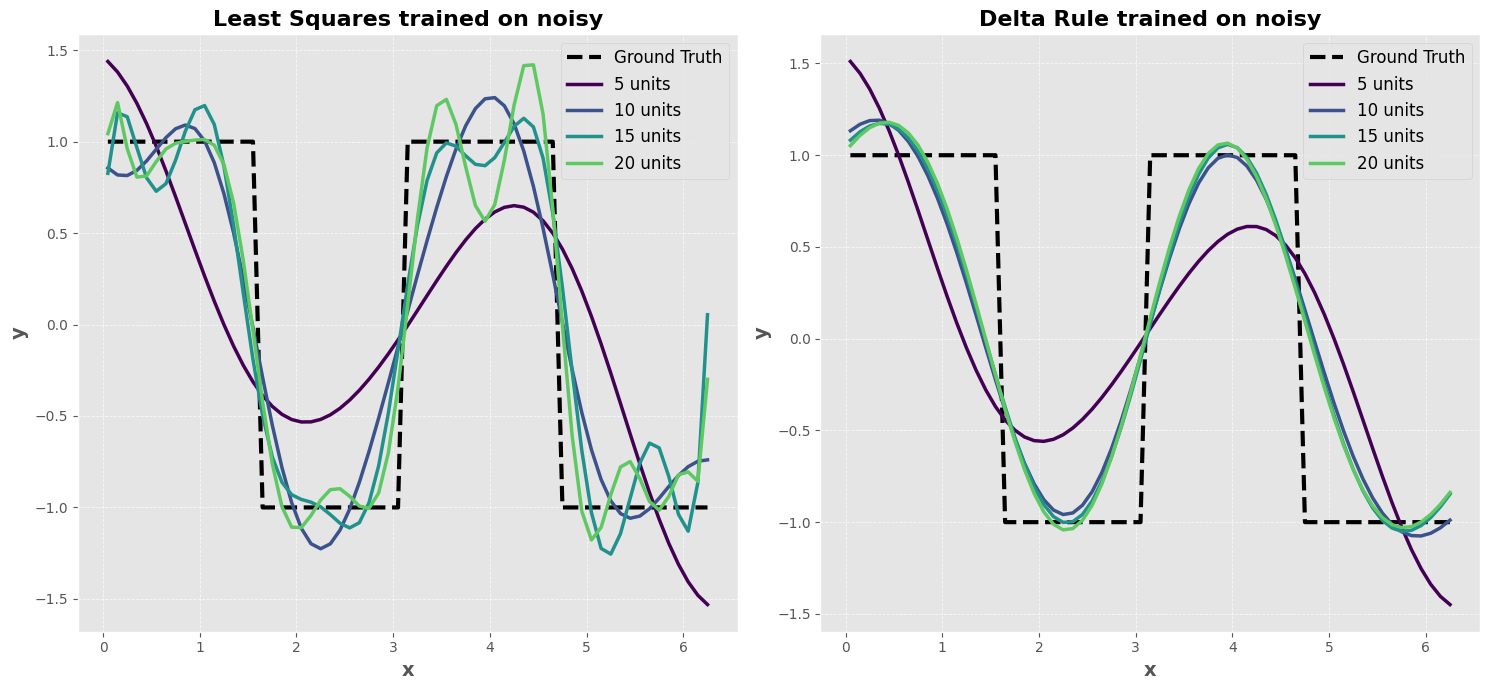

In [18]:
profile_clean_performance(x, y_noisy_square, x_test, y_square_test, nodes_preview=[5,10,15,20], 
                          kwargs_network={}, kwargs_training={})

### 3.3. Competitive learning (CL) to initialise RBF units

#### 3.3.1. Compare the CL-based approach with your earlier RBF network where you manually positioned RBF nodes in the input space. Pay attention to convergence, generalisation performance and the resulting position of nodes.

In [19]:

def rbf_pos_preview(x, y, kwargs_network={}):
    if 'node_pos' in kwargs_network:
        node_pos = kwargs_network['node_pos']
        kwargs_network.pop('node_pos')
    else:
        node_pos = DEFAULT_NODE_POS  # Fixed: Corrected variable name

    fig = plt.figure(figsize=(15,5))
    
    table_data = []  # Store values for printing

    for plot, pos in enumerate(node_pos):
        fig.add_subplot(130+plot+1)
        plt.plot(x, y, label="Input")
        model = GaussianRBFNetwork(data=x, node_pos=pos, **kwargs_network)
        
        for j, mu in enumerate(model.mu):
            rbf = np.exp(-(x-mu)**2/(2*model.cov[j]))
            plt.plot(x, rbf, label=("RBF" if j == 0 else None))

            # Store values for the table
            table_data.append({"Node Position": pos, "RBF Center (mu)": mu, "Covariance (cov)": model.cov[j]})

        plt.title(pos.capitalize())
        plt.legend()

    # Convert to DataFrame and print as a table
    df = pd.DataFrame(table_data)
    print("\nRBF Position Data:")
    print(df.to_string(index=False))  # Prints without row indices for clarity

    plt.show()



RBF Position Data:
Node Position      RBF Center (mu)  Covariance (cov)
       random                [2.2]                 1
       random                [4.9]                 1
       random [1.2000000000000002]                 1
       random [2.4000000000000004]                 1
       random                [4.2]                 1
        equal                [0.0]                 1
        equal               [1.55]                 1
        equal                [3.1]                 1
        equal               [4.65]                 1
        equal                [6.2]                 1
           cl [3.3717261631792628]                 1
           cl  [5.630959983767485]                 1
           cl  [1.846392232311374]                 1
           cl [4.5184784102762565]                 1
           cl [0.5972451216888864]                 1


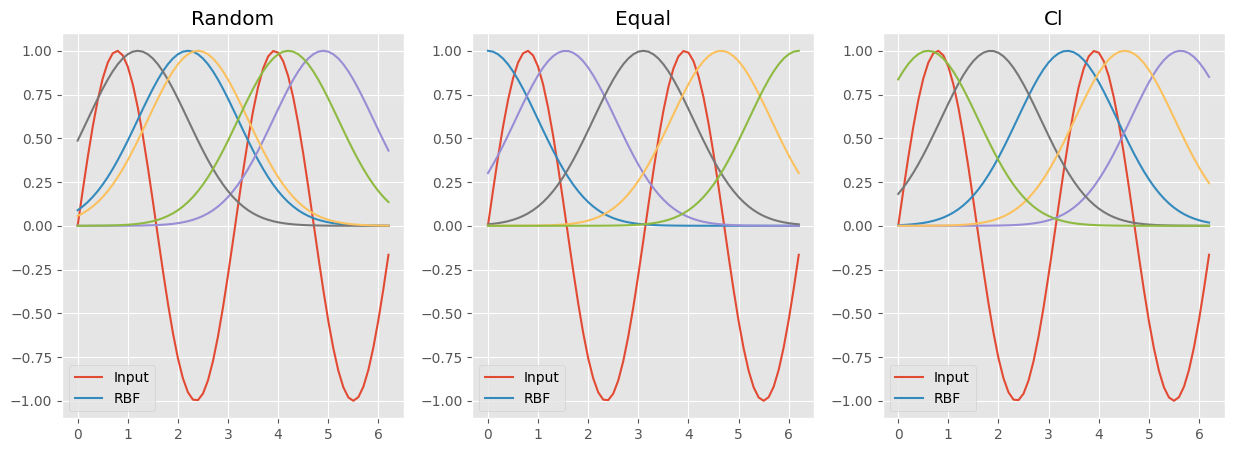

In [20]:
rbf_pos_preview(x , y_sin, kwargs_network={'nodes': 5, 'node_pos': ['random','equal','cl']})

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def rbf_pos_compare(x, y, x_test, y_test, kwargs_network=None, kwargs_training=None, runs=DEFAULT_RUNS):
    if kwargs_network is None:
        kwargs_network = {}
    if kwargs_training is None:
        kwargs_training = {}

    if 'node_pos' in kwargs_network:
        node_pos = kwargs_network['node_pos']
        kwargs_network.pop('node_pos')
    else:
        node_pos = DEFAULT_NODE_POS
        
    if 'nodes' in kwargs_network:
        nodes = kwargs_network['nodes']
        kwargs_network.pop('nodes')
    else:
        nodes = DEFAULT_NODES

    if 'epochs' in kwargs_training:
        epochs = kwargs_training['epochs']
        kwargs_training.pop('epochs')
    else:
        epochs = DEFAULT_EPOCHS_DELTA

    cmap = plt.get_cmap('tab10')
    
    # Data storage for printing
    table_data = []

    for i, pos in enumerate(node_pos):
        for r in range(runs):
            model = GaussianRBFNetwork(data=x, nodes=nodes, node_pos=pos, **kwargs_network)
            residuals = []
            for epoch in range(epochs):
                model.delta_rule_train(x, y, epochs=1, improve=True, **kwargs_training)
                predictions_test = model.predict(x_test)
                errors = predictions_test - y_test.reshape(y_test.shape[0], 1)
                residual_error = np.mean(np.abs(errors))
                residuals.append(residual_error)

                # Store values for the table
                table_data.append({"Epoch": epoch + 1, "Node Position": pos, "Residual Error": residual_error})

            plt.plot(range(1, epochs + 1), residuals, color=cmap(i), alpha=0.3, linewidth=3,
                     label=(pos.capitalize() if r == 0 else None))

    plt.xlabel("Epoch")
    plt.ylabel("Residual Error")
    plt.legend()

    # Convert to DataFrame and print as a table
    df = pd.DataFrame(table_data)
    print("\nResidual Error Values:")
    print(df.to_string(index=False))  # Prints without row indices for clarity



Residual Error Values:
 Epoch Node Position  Residual Error
     1         equal        1.941140
     2         equal        1.439817
     3         equal        1.080181
     4         equal        0.815784
     5         equal        0.619596
     6         equal        0.474240
     7         equal        0.368117
     8         equal        0.291151
     9         equal        0.234722
    10         equal        0.192621
     1         equal        2.129821
     2         equal        1.545121
     3         equal        1.130375
     4         equal        0.832651
     5         equal        0.617848
     6         equal        0.463059
     7         equal        0.353924
     8         equal        0.274256
     9         equal        0.214882
    10         equal        0.172584
     1         equal        1.480971
     2         equal        1.097598
     3         equal        0.820194
     4         equal        0.618657
     5         equal        0.469118
     6        

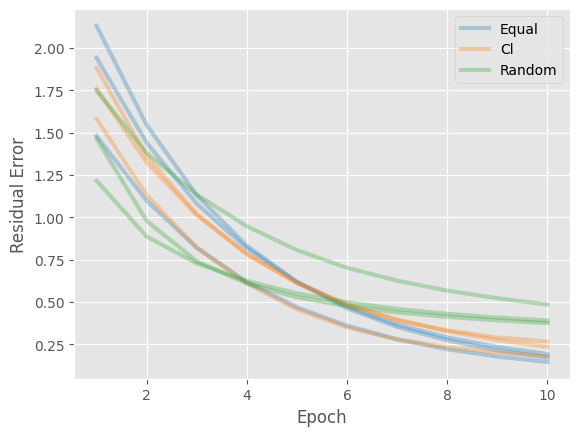

In [22]:
rbf_pos_compare(x, y_sin, x_test, y_sin_test, 
                kwargs_network={'nodes': 23,
                                'node_pos': ['equal','cl',"random"],
                                'node_std': 0.1},
                kwargs_training={'learning_rate': 0.01,
                                 'epochs': 10},
                runs=3)

#### 3.3.2. Introduce a strategy to avoid dead units, e.g. by having more than a single winner.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Circle

def plot_units(mus, covs, color, label=None):
    global ax  # Ensure ax is globally accessible

    # Store values for printing
    table_data = []

    for i, (mu, cov) in enumerate(zip(mus, covs)):
        ax.scatter(*mu, color=color, label=(label if i == 0 else None))
        
        # Create the covariance circle
        c = Circle(mu, radius=np.sqrt(cov), color=color, fill=False, linewidth=2)
        ax.add_artist(c)

        # Store values for table display
        table_data.append({"RBF Center (mu)": mu, "Covariance (cov)": cov})

    # Convert to DataFrame and print as a table
    df = pd.DataFrame(table_data)
    print("\nRBF Unit Values:")
    print(df.to_string(index=False))  # Print table without row indices for clarity



RBF Unit Values:
RBF Center (mu)  Covariance (cov)
       (-5, -5)                 4
         (5, 5)                 4
         (0, 0)                 4
CL summary:
  - Weights and Winning Times are:
 x:  [-5. -5.]  ->  0
 x:  [5. 5.]  ->  0
 x:  [-0.04479922 -0.37947046]  ->  10000

RBF Unit Values:
                              RBF Center (mu)  Covariance (cov)
                                 [-5.0, -5.0]               4.0
                                   [5.0, 5.0]               4.0
[-0.044799217260321225, -0.37947046231437004]               4.0
CL summary:
  - Weights and Winning Times are:
 x:  [ 0.07447503 -1.01834898]  ->  3328
 x:  [0.33371665 0.46387589]  ->  3338
 x:  [-1.05204687  0.12868487]  ->  3334

RBF Unit Values:
                           RBF Center (mu)  Covariance (cov)
 [0.07447503025696754, -1.018348982729155]               4.0
  [0.3337166539079006, 0.4638758871971676]               4.0
[-1.0520468717750415, 0.12868486578807406]               4.0

RBF Unit V

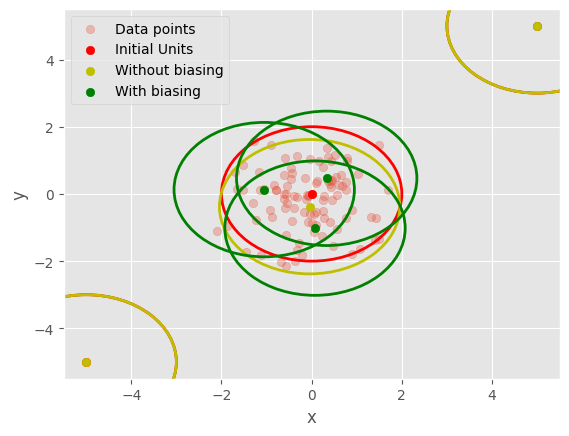

In [24]:


fig, ax = plt.subplots(1, 1)

# Plot datapoints
x, y = np.hsplit(np.random.multivariate_normal((0,0), np.eye(2), size=(100)), 2)
ax.scatter(x, y, label="Data points", alpha=0.3)

# Plot initial units
mus = [(-5,-5), (5,5), (0,0)]
std = 2
covs = np.full(len(mus), std**2)
plot_units(mus, covs, color='r', label="Initial Units")

# Store values for printing
table_data = []

# Print initial unit values
for mu, cov in zip(mus, covs):
    table_data.append({"Stage": "Initial", "RBF Center (mu)": mu, "Covariance (cov)": cov})

# Plot final units without biasing
model = GaussianRBFNetwork(data=np.hstack((x,y)), nodes=len(mus), node_pos='manual')
model.mu = np.array(mus, dtype=float)
model.cov = np.array(covs, dtype=float)
model.init_kernels_cl(std=std, random_start=False, learning_rate=0.1, verbose=True, bias=False)
plot_units(model.mu, model.cov, color='y', label="Without biasing")

# Store values for printing
for mu, cov in zip(model.mu, model.cov):
    table_data.append({"Stage": "Without Biasing", "RBF Center (mu)": tuple(mu), "Covariance (cov)": cov})

# Plot final units with biasing
model.mu = np.array(mus, dtype=float)
model.cov = np.array(covs, dtype=float)
model.init_kernels_cl(std=std, random_start=False, learning_rate=0.1, bias=True, bias_weight=0.1,
                      verbose=True)
plot_units(model.mu, model.cov, color='g', label="With biasing")

# Store values for printing
for mu, cov in zip(model.mu, model.cov):
    table_data.append({"Stage": "With Biasing", "RBF Center (mu)": tuple(mu), "Covariance (cov)": cov})

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

# Convert to DataFrame and print as a table
df = pd.DataFrame(table_data)
print("\nRBF Unit Values:")
print(df.to_string(index=False))  # Print table without row indices for clarity


#### 3.3.3. Configure an RBF network with the use of CL for positioning the RBF units to approximate a two-dimensional function, i.e. from R^2 to R^2 (Approximate Ballistic function)



Ballistic Data:
 Angle  Velocity  Distance  Height
 0.896     0.540     0.093   0.260
 0.279     0.859     0.566   0.122
 0.307     0.403     0.133   0.032
 0.974     0.546     0.024   0.273
 0.069     0.903     0.175   0.009
 0.290     0.448     0.159   0.036
 0.015     0.085     0.000   0.000
 0.686     0.507     0.215   0.183
 0.277     0.434     0.144   0.031
 0.743     0.705     0.359   0.386
 0.433     0.752     0.552   0.205
 0.251     0.154     0.017   0.003
 0.661     0.620     0.336   0.262
 0.096     0.823     0.202   0.014
 0.771     0.403     0.107   0.130
 0.992     0.643     0.011   0.379
 0.988     0.763     0.022   0.533
 0.007     0.910     0.019   0.000
 0.689     0.805     0.537   0.464
 0.228     0.274     0.050   0.009
 0.894     0.753     0.186   0.506
 0.276     0.100     0.008   0.002
 0.227     0.482     0.152   0.026
 0.542     0.254     0.064   0.033
 0.999     0.673     0.001   0.415
 0.530     0.572     0.326   0.164
 0.073     0.257     0.015   0.001
 0.

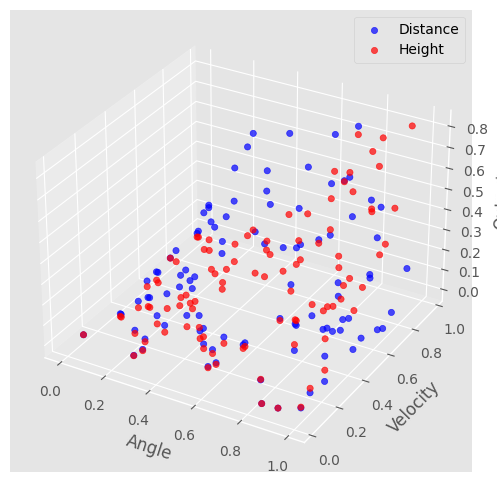

In [25]:

# Load data
angles, velocities, distances, heights = np.hsplit(np.genfromtxt("data/ballist.dat"), 4)
inputs = np.hstack((angles, velocities))

# 3D predictions
fig = plt.figure(figsize=(6, 6))  # Slightly larger figure for better visibility
fig3d = fig.add_subplot(1, 1, 1, projection='3d')
fig3d.scatter(angles, velocities, distances, label="Distance", color='blue', alpha=0.7)
fig3d.scatter(angles, velocities, heights, label="Height", color='red', alpha=0.7)
fig3d.set_xlabel("Angle")
fig3d.set_ylabel("Velocity")
fig3d.set_zlabel("Output")
fig3d.legend()

# Store values in a table
table_data = []
for angle, velocity, distance, height in zip(angles.flatten(), velocities.flatten(), distances.flatten(), heights.flatten()):
    table_data.append({"Angle": angle, "Velocity": velocity, "Distance": distance, "Height": height})

# Convert to DataFrame and print as a table
df = pd.DataFrame(table_data)
print("\nBallistic Data:")
print(df.to_string(index=False))  # Print table without row indices for clarity

# Show plot
plt.show()


In [26]:
model = GaussianRBFNetwork(data=inputs, nodes=5, node_pos='cl', node_std=0.1, cl_bias=True, 
                           cl_verbose=True)

CL summary:
  - Weights and Winning Times are:
 x:  [0.63044395 0.73607264]  ->  1999
 x:  [0.89652035 0.64115936]  ->  1996
 x:  [0.13997838 0.71704415]  ->  1997
 x:  [0.73243861 0.26103812]  ->  2003
 x:  [0.23417632 0.28929769]  ->  2005



Original Data Points:
 Angle  Velocity
 0.896     0.540
 0.279     0.859
 0.307     0.403
 0.974     0.546
 0.069     0.903
 0.290     0.448
 0.015     0.085
 0.686     0.507
 0.277     0.434
 0.743     0.705
 0.433     0.752
 0.251     0.154
 0.661     0.620
 0.096     0.823
 0.771     0.403
 0.992     0.643
 0.988     0.763
 0.007     0.910
 0.689     0.805
 0.228     0.274
 0.894     0.753
 0.276     0.100
 0.227     0.482
 0.542     0.254
 0.999     0.673
 0.530     0.572
 0.073     0.257
 0.244     0.410
 0.001     0.718
 0.012     0.912
 0.983     0.251
 0.815     0.315
 0.631     0.261
 0.629     0.251
 0.803     0.466
 0.062     0.535
 0.438     0.250
 0.909     0.499
 0.860     0.452
 0.461     0.702
 0.714     0.668
 0.610     0.695
 0.869     0.467
 0.366     0.526
 0.713     0.967
 0.765     0.405
 0.890     0.472
 0.216     0.462
 0.039     0.491
 0.343     0.566
 0.264     0.057
 0.815     0.898
 0.038     0.704
 0.483     0.204
 0.185     0.184
 0.972     0.162
 0.239  

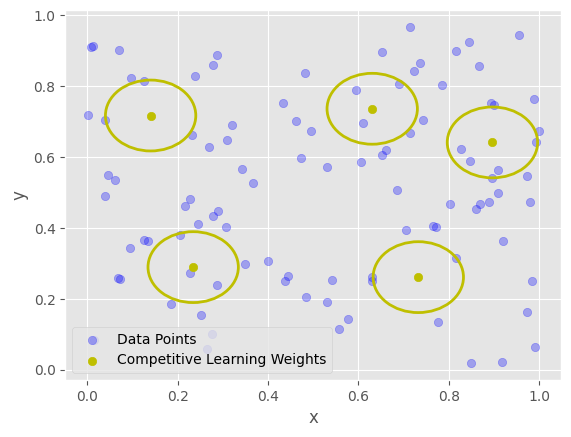

In [27]:

fig, ax = plt.subplots(1, 1)

# Plot data points
ax.scatter(angles, velocities, alpha=0.3, color="blue", label="Data Points")

# Store data for printing
data_table = []

for angle, velocity in zip(angles.flatten(), velocities.flatten()):
    data_table.append({"Angle": angle, "Velocity": velocity})

# Print Data Points Table
df_data = pd.DataFrame(data_table)
print("\nOriginal Data Points:")
print(df_data.to_string(index=False))  # Print table without row indices

# Plot final units without biasing
plot_units(model.mu, model.cov, color='y', label="Competitive Learning Weights")

# Store final unit values for printing
unit_table = []

for mu, cov in zip(model.mu, model.cov):
    unit_table.append({"Final RBF Center (mu)": tuple(mu), "Covariance (cov)": cov})

# Print Final Unit Values Table
df_units = pd.DataFrame(unit_table)
print("\nFinal Competitive Learning Weights:")
print(df_units.to_string(index=False))  # Print table without row indices

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

# Show plot
plt.show()


In [29]:
import numpy as np

# Shuffle samples
shuffle = np.random.permutation(inputs.shape[0])
inputs_shuffled = inputs[shuffle, :]
distances_shuffled = distances[shuffle, :]
heights_shuffled = heights[shuffle, :]

# Print a sample of shuffled data
print("\nSample Shuffled Data:")
for i in range(0, len(inputs_shuffled), max(1, len(inputs_shuffled)//10)):  # Print every couple of data points
    print(f"Angle: {inputs_shuffled[i, 0]:.2f}, Velocity: {inputs_shuffled[i, 1]:.2f}, Distance: {distances_shuffled[i, 0]:.2f}, Height: {heights_shuffled[i, 0]:.2f}")

# Split into training and validation data
n_train = int(0.8 * inputs_shuffled.shape[0])
inputs_train, inputs_val = inputs_shuffled[:n_train, :], inputs_shuffled[n_train:, :]
distances_train, distances_val = distances_shuffled[:n_train, :], distances_shuffled[n_train:, :]
heights_train, heights_val = heights_shuffled[:n_train, :], heights_shuffled[n_train:, :]

# Print a sample of training and validation data
print("\nSample Training Data:")
for i in range(0, len(inputs_train), max(1, len(inputs_train)//10)):
    print(f"Angle: {inputs_train[i, 0]:.2f}, Velocity: {inputs_train[i, 1]:.2f}, Distance: {distances_train[i, 0]:.2f}")

print("\nSample Validation Data:")
for i in range(0, len(inputs_val), max(1, len(inputs_val)//10)):
    print(f"Angle: {inputs_val[i, 0]:.2f}, Velocity: {inputs_val[i, 1]:.2f}, Distance: {distances_val[i, 0]:.2f}")

# Read test data
angles_test, velocities_test, distances_test, heights_test = np.hsplit(np.genfromtxt("data/balltest.dat"), 4)
inputs_test = np.hstack((angles_test, velocities_test))

# Print a sample of test data
print("\nSample Test Data:")
for i in range(0, len(inputs_test), max(1, len(inputs_test)//10)):
    print(f"Angle: {inputs_test[i, 0]:.2f}, Velocity: {inputs_test[i, 1]:.2f}, Distance: {distances_test[i, 0]:.2f}")

def gridsearch(inputs_train, outputs_train, inputs_val, outputs_val, kwargs_network={}, 
               kwargs_training={}, runs=DEFAULT_RUNS, verbose=False):
    
    if verbose:
        cols = ["Units", "Sigma", "Training", "Node position", "MSE (mean)", "MSE (std)"]
        print("\nGrid Search Progress:")
        print(f"{cols}")

    # Extract parameters
    nodes = kwargs_network.pop('nodes', DEFAULT_NODES)
    node_pos = kwargs_network.pop('node_pos', DEFAULT_NODE_POS)
    node_std = kwargs_network.pop('node_std', DEFAULT_NODE_STD)
    trainings = kwargs_training.pop('training', DEFAULT_TRAINING)

    mse_min = np.inf
    best_model = {}

    for ns in [nodes] if isinstance(nodes, (float, int)) else nodes:
        for sigma in [node_std] if isinstance(node_std, (float, int)) else node_std:
            for training in [trainings] if isinstance(trainings, str) else trainings:
                for pos in [node_pos] if isinstance(node_pos, str) else node_pos:
                    mses = []
                    for run in range(runs):
                        model = GaussianRBFNetwork(data=inputs_train, nodes=ns, node_std=sigma, 
                                                   node_pos=pos, **kwargs_network)
                        # Train Model
                        if training == 'least_squares':
                            model.least_squares_fit(inputs_train, outputs_train)
                        elif training == 'delta_rule':
                            model.delta_rule_train(inputs_train, outputs_train, **kwargs_training)
                        
                        # Validate
                        predictions_val = model.predict(inputs_val)
                        errors = predictions_val - outputs_val.reshape(outputs_val.shape[0], 1)
                        mse = np.mean(np.abs(errors))
                        mses.append(mse)

                        # Print progress every couple of runs
                        if run % max(1, runs//5) == 0:
                            print(f"Run {run+1}/{runs}: Nodes={ns}, Sigma={sigma}, Training={training}, Position={pos}, MSE={mse:.6f}")

                    mse_mean = np.mean(mses)
                    mse_std = np.std(mses)

                    if mse_mean < mse_min:
                        best_model = {"nodes": ns, "sigma": sigma, "training": training, 
                                      "node_pos": pos, "mse_mean": mse_mean, "mse_std": mse_std}
                        mse_min = mse_mean
                    
                    if verbose:
                        print([ns, sigma, training, pos, mse_mean, mse_std])

    print("\nBest Model Found:")
    print(best_model)
    
    return best_model



Sample Shuffled Data:
Angle: 0.22, Velocity: 0.46, Distance: 0.13, Height: 0.02
Angle: 0.70, Velocity: 0.39, Distance: 0.12, Height: 0.11
Angle: 0.29, Velocity: 0.45, Distance: 0.16, Height: 0.04
Angle: 1.00, Velocity: 0.67, Distance: 0.00, Height: 0.41
Angle: 0.63, Velocity: 0.25, Distance: 0.06, Height: 0.04
Angle: 0.99, Velocity: 0.06, Distance: 0.00, Height: 0.00
Angle: 0.78, Velocity: 0.14, Distance: 0.01, Height: 0.01
Angle: 0.99, Velocity: 0.64, Distance: 0.01, Height: 0.38
Angle: 0.89, Velocity: 0.47, Distance: 0.07, Height: 0.20
Angle: 0.91, Velocity: 0.50, Distance: 0.07, Height: 0.22

Sample Training Data:
Angle: 0.22, Velocity: 0.46, Distance: 0.13
Angle: 0.34, Velocity: 0.57, Distance: 0.28
Angle: 0.69, Velocity: 0.51, Distance: 0.21
Angle: 0.71, Velocity: 0.97, Distance: 0.73
Angle: 0.90, Velocity: 0.54, Distance: 0.09
Angle: 0.63, Velocity: 0.25, Distance: 0.06
Angle: 0.29, Velocity: 0.89, Distance: 0.62
Angle: 0.61, Velocity: 0.69, Distance: 0.45
Angle: 0.45, Velocity:

In [30]:
#distances
best_model_distances = gridsearch(inputs_train, distances_train, inputs_val, distances_val,
                                  kwargs_network={'nodes': [10,20,30],
                                                  'node_pos':['cl','random','equal'],
                                                  'node_std': [0.1,0.25,0.5],
                                                  "cl_bias":True},
                                  kwargs_training={'training': ['least_squares','delta_rule'],
                                                   "epochs":25},
                                  runs=3, verbose=False)

Run 1/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=cl, MSE=0.038393
Run 2/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=cl, MSE=0.048992
Run 3/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=cl, MSE=0.043620
Run 1/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=random, MSE=0.070064
Run 2/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=random, MSE=0.042453
Run 3/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=random, MSE=0.063543
Run 1/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=equal, MSE=0.151419
Run 2/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=equal, MSE=0.151419
Run 3/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=equal, MSE=0.151419
Run 1/3: Nodes=10, Sigma=0.1, Training=delta_rule, Position=cl, MSE=nan
Run 2/3: Nodes=10, Sigma=0.1, Training=delta_rule, Position=cl, MSE=nan
Run 3/3: Nodes=10, Sigma=0.1, Training=delta_rule, Position=cl, MSE=nan
Run 1/3: Nodes=10, Sigma=0.1, Training=delt

In [ ]:
# Good model for heights
best_model_heights = gridsearch(inputs_train, heights_train, inputs_val, heights_val,
                                kwargs_network={'nodes': [10,20,30],
                                                'node_pos':['cl','random','equal'],
                                                'node_std': [0.1,0.25,0.5],
                                                "cl_bias":True},
                                kwargs_training={'training': ['least_squares','delta_rule'],
                                                 "epochs":25},
                                runs=3, verbose=False)

Run 1/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=cl, MSE=0.038917
Run 2/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=cl, MSE=0.043503
Run 3/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=cl, MSE=0.037378
Run 1/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=random, MSE=0.058019
Run 2/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=random, MSE=0.081382
Run 3/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=random, MSE=0.036522
Run 1/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=equal, MSE=0.150274
Run 2/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=equal, MSE=0.150274
Run 3/3: Nodes=10, Sigma=0.1, Training=least_squares, Position=equal, MSE=0.150274
Run 1/3: Nodes=10, Sigma=0.1, Training=delta_rule, Position=cl, MSE=nan
Run 2/3: Nodes=10, Sigma=0.1, Training=delta_rule, Position=cl, MSE=nan
Run 3/3: Nodes=10, Sigma=0.1, Training=delta_rule, Position=cl, MSE=nan
Run 1/3: Nodes=10, Sigma=0.1, Training=delt

In [ ]:



def evaluate(model, inputs_test, outputs_test, show_points=True, show_surface=True):
    # Compute prediction
    predictions_test = model.predict(inputs_test)
    mse = np.mean(np.abs(predictions_test - outputs_test.reshape(outputs_test.shape[0], 1)))
    
    # Set up figure
    fig = plt.figure(figsize=(15,7.5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    cmap = plt.get_cmap('tab10')

    # Scatter plots
    ax1.scatter(inputs_test[:,0], inputs_test[:,1], outputs_test, label="Ground Truth")
    ax1.scatter(inputs_test[:,0], inputs_test[:,1], predictions_test, color=cmap(1), label="Prediction")
    ax2.scatter(inputs_test[:,0], inputs_test[:,1], abs(predictions_test - outputs_test), color=cmap(2),
                alpha=0.5, label="|Prediction - Ground Truth| - MSE "+str(mse))

    # Format axes
    for ax in ax1, ax2:
        ax.set_xlabel("Angle")
        ax.set_ylabel("Velocity")
        ax.legend()
    ax2.ticklabel_format(style='sci', axis='z', scilimits=(0,0))

    # Print sample test data
    print("\nSample Test Data:")
    table_data = []
    for i in range(0, len(inputs_test), max(1, len(inputs_test)//10)):  # Print every few data points
        angle, velocity = inputs_test[i]
        ground_truth = outputs_test[i]
        prediction = predictions_test[i][0]
        error = abs(prediction - ground_truth)
        table_data.append({"Angle": angle, "Velocity": velocity, "Ground Truth": ground_truth, 
                           "Prediction": prediction, "|Error|": error})

    # Convert to DataFrame and print table
    df = pd.DataFrame(table_data)
    print(df.to_string(index=False))  # Print without row indices

    # Print Mean Absolute Error
    print("\nMean Absolute Error (MSE):", mse)

    # Show plot
    plt.show()





Sample Test Data:
 Angle  Velocity Ground Truth  Prediction                  |Error|
 0.658     0.365      [0.117]    0.117487  [0.0004871402634494121]
 0.554     0.184      [0.033]    0.033212 [0.00021216863508879968]
 0.648     0.180      [0.029]    0.028925  [7.473376587449967e-05]
 0.761     0.934      [0.594]    0.595426  [0.0014258846523430568]
 0.629     0.020        [0.0]    0.001581  [0.0015814248832555222]
 0.364     0.876      [0.698]    0.698614  [0.0006141568063715575]
 0.892     0.746      [0.186]    0.185655  [0.0003452393568395551]
 0.134     0.203      [0.017]    0.017065   [6.48402096560391e-05]
 0.308     0.488      [0.196]    0.196089  [8.882442616958697e-05]
 0.088     0.169      [0.008]    0.007730 [0.00027047904776100057]

Mean Absolute Error (MSE): 0.000680112539183904


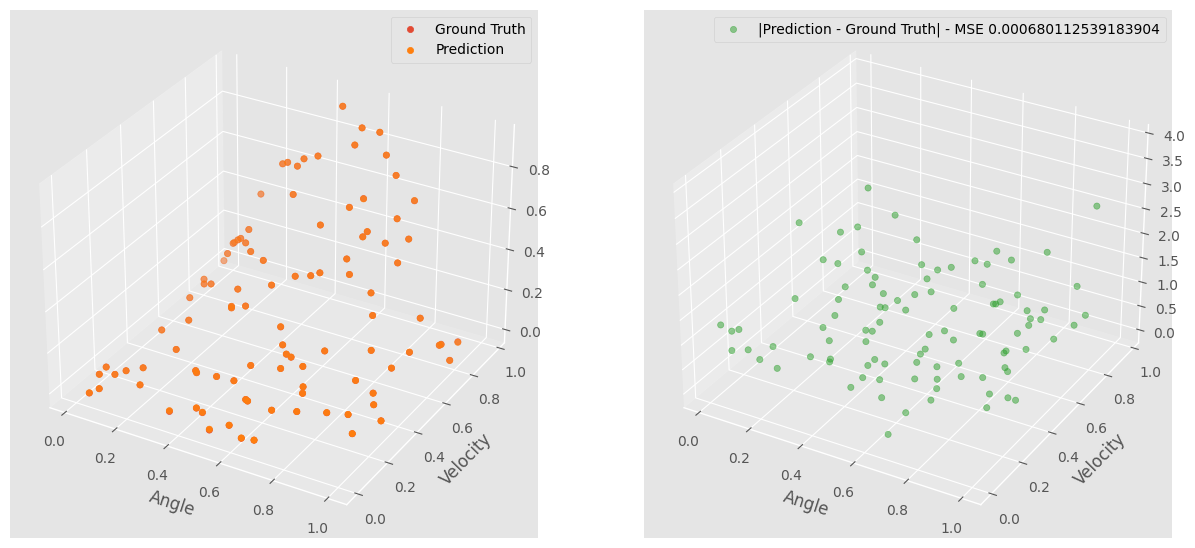

In [33]:
#  distances
kwargs_network = {"cl_bias": True}
kwargs_training = {"epochs": 25}
nodes = best_model_distances["nodes"]
sigma = best_model_distances["sigma"]
training = best_model_distances["training"]
node_pos = best_model_distances["node_pos"]

model_distances = GaussianRBFNetwork(data=inputs_train, nodes=nodes, node_std=sigma, node_pos=node_pos,
                                     **kwargs_network)

if training == 'least_squares':
    model_distances.least_squares_fit(inputs_train, distances_train)
elif training == 'delta_rule':
    model_distances.delta_rule_train(inputs_train, distances_train, **kwargs_training)

evaluate(model_distances, inputs_test, distances_test)


Sample Test Data:
 Angle  Velocity Ground Truth  Prediction                  |Error|
 0.658     0.365       [0.09]    0.090032  [3.200234624975429e-05]
 0.554     0.184      [0.018]    0.018099  [9.912454478279778e-05]
 0.648     0.180      [0.022]    0.021805 [0.00019502333785912512]
 0.761     0.934      [0.693]    0.691685  [0.0013148384059910034]
 0.629     0.020        [0.0]    0.001185  [0.0011846981090677389]
 0.364     0.876      [0.206]    0.206449 [0.00044930459260991706]
 0.892     0.746      [0.496]    0.496101 [0.00010148028233780693]
 0.134     0.203      [0.002]    0.002393 [0.00039292564438642326]
 0.308     0.488      [0.047]    0.047308 [0.00030765546191761917]
 0.088     0.169        [0.0]    0.001122  [0.0011216275887306892]

Mean Absolute Error (MSE): 0.0005269475480875515


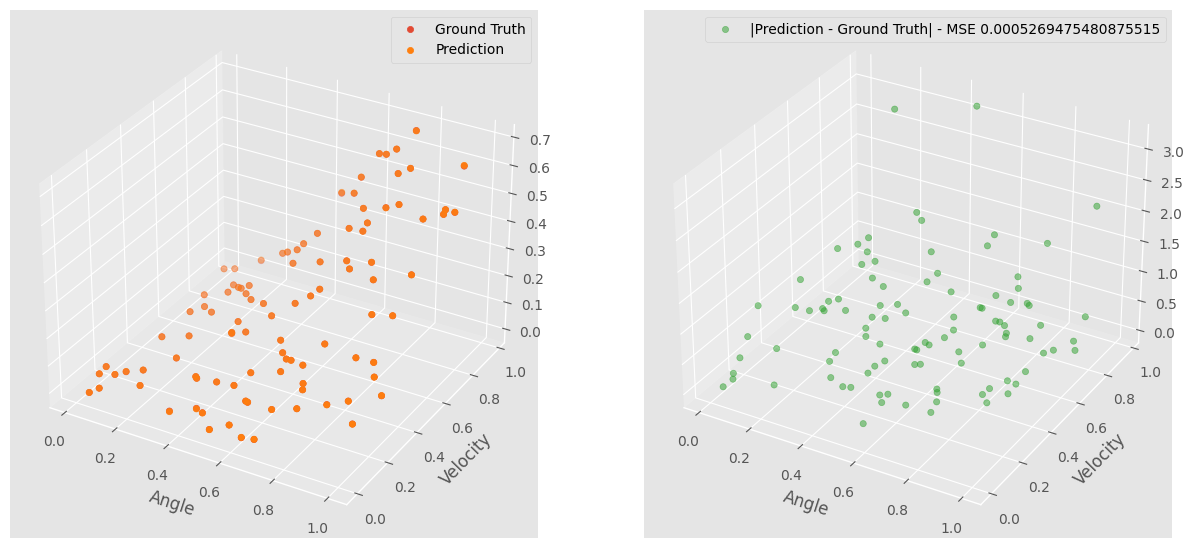

In [34]:
# heights
kwargs_network = {"cl_bias": True}
kwargs_training = {"epochs": 25}
nodes = best_model_heights["nodes"]
sigma = best_model_heights["sigma"]
training = best_model_heights["training"]
node_pos = best_model_heights["node_pos"]
model_heights = GaussianRBFNetwork(data=inputs_train, nodes=nodes, node_std=sigma, node_pos=node_pos,
                                   **kwargs_network)

if training == 'least_squares':
    model_heights.least_squares_fit(inputs_train, heights_train)
elif training == 'delta_rule':
    model_heights.delta_rule_train(inputs_train, heights_train, **kwargs_training)

evaluate(model_heights, inputs_test, heights_test)